# Fitting quasi-normal modes in GW190521

We demonstrate how to use `ringdown` to fit damped sinusoids in data from GW190521. We will fit a model composed of three long-lived (fundamental) modes, following [Siegel et al. (2023)](https://arxiv.org/abs/2307.11975). We will also use this as an example for loading open data directly from the Gravitational Wave Open Science Center (GWOSC) using [GWpy](http://gwpy.github.io).

<div class="alert alert-info">

Note

The [GWpy package](http://gwpy.github.io/) is only an _optional_ dependence for `ringdown`: you should install it before running this notebook (e.g., `pip install gwpy`); alternatively, you can download the data separately and load it directly from disk as in the GW150914 example.

</div>

In [ ]:
%pip install gwpy

## Preliminaries

We begin with some standard imports and global settings.

<div class="alert alert-info">

Tip

`ringdown` can run on GPUs! You can activate this through `numpyro.set_platform`. If running on a GPU, you will likely see significant performance improvements by using single precision, i.e., `config.update("jax_enable_x64", False)`; if doing so, `ringdown` will automatically attempt to scale quantities so that single precision is safe---but you should always check that this works for your data.

</div>

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# disable numpy multithreading to avoid conflicts
# with jax multiprocessing in numpyro
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import h5py
import pandas as pd

# import jax and set it up to use double precision
from jax import config
config.update("jax_enable_x64", True)

# import numpyro and set it up to use 4 CPU devices
import numpyro
numpyro.set_host_device_count(4)
numpyro.set_platform('cpu')

# we will use matplotlib, arviz and seaborn for some of the plotting
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# disable some warning shown by importing LALSuite from a notebook
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# import ringdown package
import ringdown as rd

# set plotting context
sns.set_context('notebook')
sns.set_palette('colorblind')

## Fitting Kerr modes

In this example, we will fit three prograde modes to the GW190521 data: $(\ell = 2, |m| = 2, n = 0)$, $(\ell = 2, |m| = 1, n = 0)$, and $(\ell = 3, |m| = 2, n = 0)$ following [Siegel et al (2023)](https://arxiv.org/pdf/2307.11975).

The fit object expects to receive a list of modes to include in the fit; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  The modes are elliptically polarized, so there is no need to specify both + and - `m` azimuthal numbers. (See [Isi & Farr (2021)](https://arxiv.org/abs/2107.05609).)

In [4]:
fit = rd.Fit(modes=[(1, -2, 2, 2, 0), (1, -2, 2, 1, 0), (1, -2, 3, 2, 0)])

We will also set an analysis time, target sky location and analysis duration. We will use some reference values corresponding to an estimate of the peak of GW190521 taken from [Siegel et al (2023)](https://arxiv.org/pdf/2307.11975), which quotes a reference time of $t_{H1} = 1242442967.4278\, s$ in the Hanford detector:

In [5]:
fit.set_target(1242442967.427804, ra=5.749613171792332, dec=-0.4237903906862163, 
               psi=1.222853265910277, duration=0.2, reference_ifo='H1')

Specifying a reference time and sky location is equivalent to specifying the times at all detectors in the network. We can also access the corresponding geocenter _target time_, which is used internally for book-keeping.

In [6]:
fit.t0

1242442967.4085817

On the other hand, the fit has no concept of _detector_ times yet because we have not specified which detector will be analyzed; we will do that next.

In [7]:
fit.analysis_times

{}

### Data and power spectrum

We will load strain data directly from GWOSC using the GWpy backend. This is achieved through the universal `fit.load_data` function, which automatically determines where to look for the data based on its arguments. In this case, the `channel='gwosc'` argument indicates that we will downloading GWOSC data directly, rather than reading it locally. If you do not have GWpy installed, this call will fail. See the documentation for `load_data` for all the accepted options and corresponding behaviors.

We will procure `seglen` seconds of data around the target time for the three detectors that contributed to this detection: LIGO Hanford (H1), LIGO Livingston (L1), and Virgo (V1).

In [8]:
fit.load_data(channel='gwosc', ifos=['H1', 'L1', 'V1'], seglen=8, sample_rate=16384, version=2)

<div class="alert alert-info">

Note

The [GWpy package](http://gwpy.github.io/) can automatically cache date, so the execution time of the above cell will vary.

</div>

Now that the fit has data, it knows how to compute target times at individual detectors:

In [9]:
fit.start_times

{'H1': 1242442967.427804, 'L1': 1242442967.4250479, 'V1': 1242442967.4030466}

As a sanity-check, we can plot of the raw strain we just loaded:

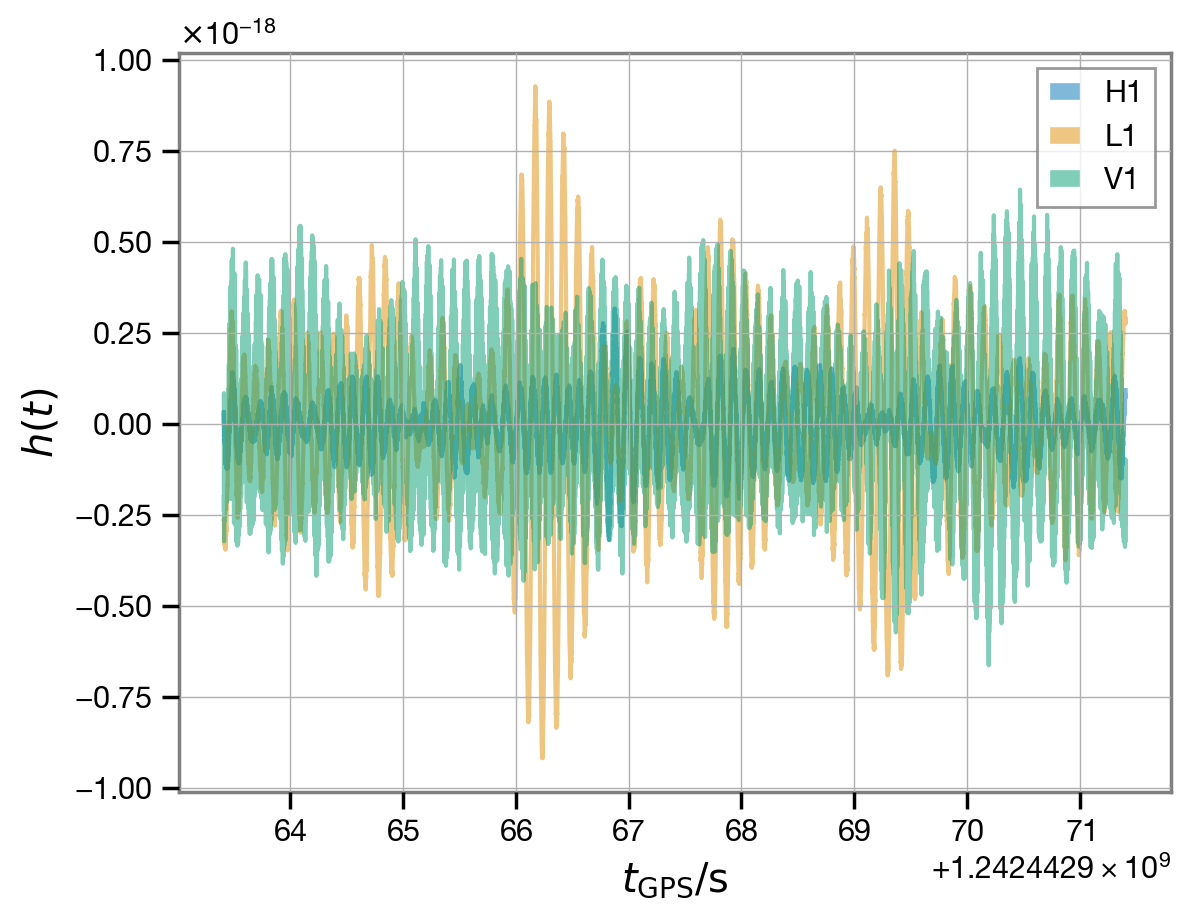

In [10]:
for ifo, data in fit.data.items():
    data[::8].plot(label=ifo, alpha=0.5)
plt.xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$');
plt.ylabel(r'$h(t)$');
plt.legend(loc='best');

These raw data are sampled at a very high rate, which is not needed for our analysis. We will _condition_ them below, after we download some further data products from the LIGO-Virgo-KAGRA (LVK) analysis, which we will use for reference.

#### Power spectrum and samples

In the GW150914 example, the ringdown analysis was self contained: we only made use of the strain data from GWOSC and target time information. Here we will show how we can incorporate other data products into our analysis. In particular, we will:

1. use a reference noise power-spectral-density (PSD) to derive a time-domain autocovariance function (ACF), rather than estimating it directly from the data;
2. download posterior samples for the remnant mass and spin estimated from the LVK analysis of the full inspiral-merger-ringdown (IMR) signal, which we will plot for reference.

Both these data products (and more), can be found in the [data release](https://dcc.ligo.org/LIGO-P2000158/public) for the LVK papers describing the [discovery](https://dcc.ligo.org/LIGO-P2000020/public) and [properties](https://dcc.ligo.org/LIGO-P2000021/public) of GW190521; for the IMR results, we will take the NRSur7dq4 waveform ([Varma et al 2019](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.1.033015)) as reference. Conveniently, both the PSD and the posterior samples are contained in a single HDF5 file.

In [ ]:
!wget -nc https://dcc.ligo.org/public/0168/P2000158/004/GW190521_posterior_samples.h5

To load the PSD, we will use the `PowerSpectrum` class provided by `ringdown`, which will allow us to easily manipulate this object and turn it into an ACF we can use; this includes `patch`ing, i.e., setting the PSD to an arbitrary high level to censor certain frequencies---this allows us to control which frequencies will contribute to the likelihood, and is analogous to setting the limits of integration (`f_min` and `f_max`) in the traditional Fourier-domain likelihood used in LVK analyses.

Likewise, we will load the posterior samples into a custom `IMRResult` object provided by _ringdown_; this is a wrapper around a _pandas_ `DataFrame` with some additional features for computing remnant mass and spin posteriors and associated ringdown mode frequencies.

In [12]:
with h5py.File('GW190521_posterior_samples.h5', 'r') as f:
    psds = {}
    for ifo in fit.ifos:
        # load frequencies and PSD values from file
        # this is a 2D array with the first column
        # being the frequency values and the second
        # column being the PSD values 
        f_p = f['NRSur7dq4']['psds'][ifo][()]
        # create a PowerSpectrum object
        p = rd.PowerSpectrum(f_p[:,1], index=f_p[:,0])
        psds[ifo] = p.patch(f_min=8, f_max=512*0.9, patch_level=1E-36)

    # load IMR posterior samples into an IMRResult object
    imr_samples = rd.IMRResult(f['NRSur7dq4']['posterior_samples'][()])

We will plot the PSDs with the data below. But first, turn them into a time-domain ACF and store them in the fit:

In [13]:
fit.acfs = {i: p.to_acf() for i, p in psds.items()}

<div class="alert alert-info">

Tip

When turning a precomputed PSD into an ACF, always make sure that the reciprocal of the frequency spacing ($T_{\rm PSD} = 1/\Delta f$) is much greater than the ringdown analysis time; we recommend at least a factor of 10x to be safe.

</div>

From now on, we do not really need the original PSDs in `psds` for the analysis, but we'll keep them around for a visual check below.

The PSDs we have loaded were produced using the BayesLine algorithm ([Littenberg & Cornish 2015](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.91.084034)) for 8 s of data sampled at 1024 Hz.

In [14]:
psds['H1'].duration, psds['H1'].f_samp

(8.0, 1024.0)

In order to use this PSD, we will have to condition our data to have a matching sampling rate. (The segment length is not important at this stage, as long as it is much longer than the segment length for our ringdown analysis, specified when we set the target---we will eventually truncate both the data and the ACF to the same lenght in the time domain.)


#### Data conditioning

We will downsample the data by a factor of 16 in order to match the reference PSDs we downloaded above. There are different downsampling methods; the `fit.condition_data` applies what we have found to be the best defaults (see documentation).

When we downsample, we want to be sure to preserve a sample as close as possible to the requested target time at each detector. One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky); the `condition_data` method accomplishes this. Here we will call it with the `preserve_acfs=True` option, so that it does not destroy the ACFs we added manually above (by default, the `condition` method will clear ACFs when you manipulate the data, so that you don't accidentally end up with mismatched data and ACFs.)

<div class="alert alert-info">

Warning

The conditioning function has a large number of options to manipulate the data in several ways. You should always make sure that the defaults make sense for your data!

</div>

In [15]:
fit.condition_data(ds=16, preserve_acfs=True)

We can visualize the segment of conditioned analysis in the Fourier domain and compare it to the PSDs we loaded above. We will plot the reference PSD together with a Welch estimate produced from the conditioned data.

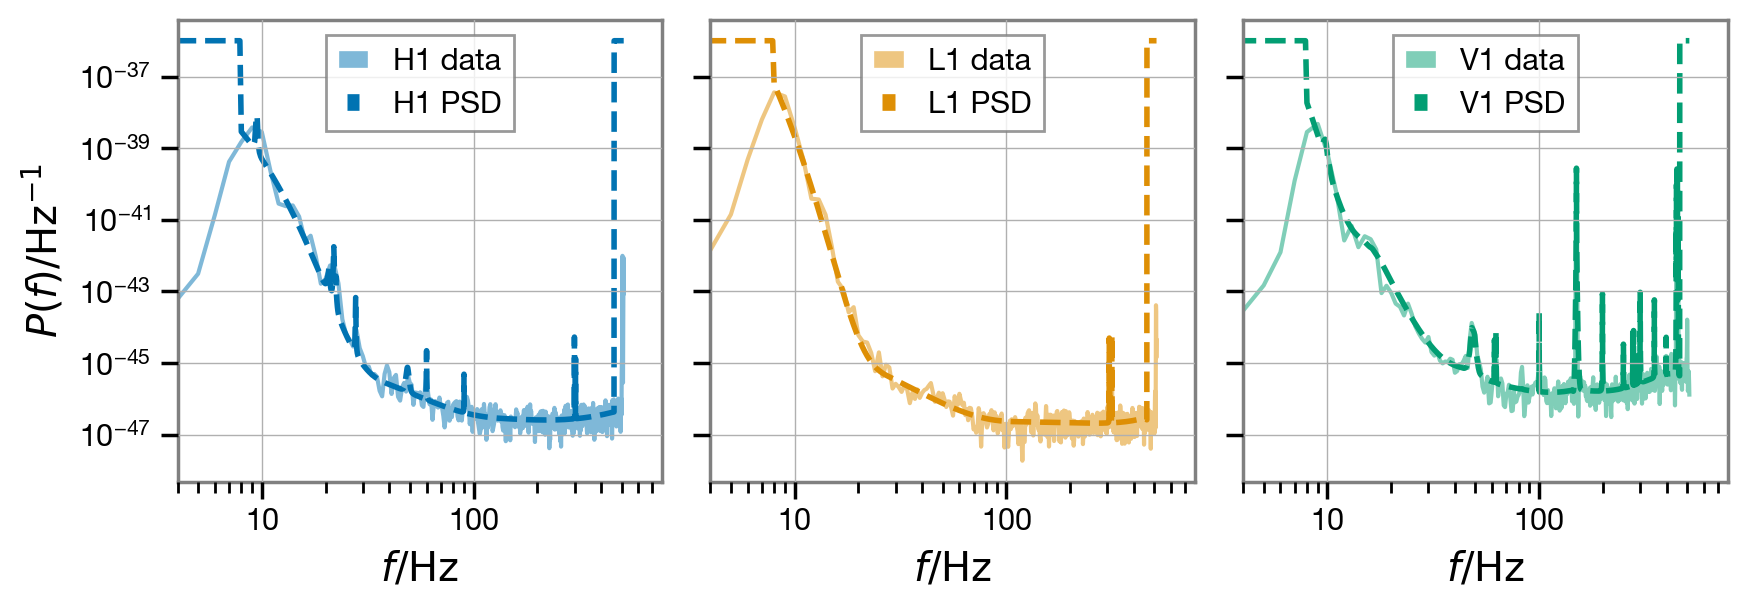

In [16]:
fig, axs = plt.subplots(1, len(fit.ifos), figsize=(10, 3), sharey=True)
fig.subplots_adjust(wspace=0.1)
axs = np.atleast_1d(axs)

for i, (ifo, data) in enumerate(fit.data.items()):
    welch_psd = data.get_psd().iloc[1:]
    
    axs[i].loglog(welch_psd, label=f'{ifo} data', alpha=0.5, c=f'C{i}')
    axs[i].loglog(psds[ifo], label=f'{ifo} PSD', ls='--', lw=2, c=f'C{i}')
    
    axs[i].legend(loc='upper center');
    axs[i].set_xlabel(r'$f / \mathrm{Hz}$');
    axs[i].set_xlim(4, None)
axs[0].set_ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$');

We can use also the ACFs to decorrelate the analysis data and plot it once again.

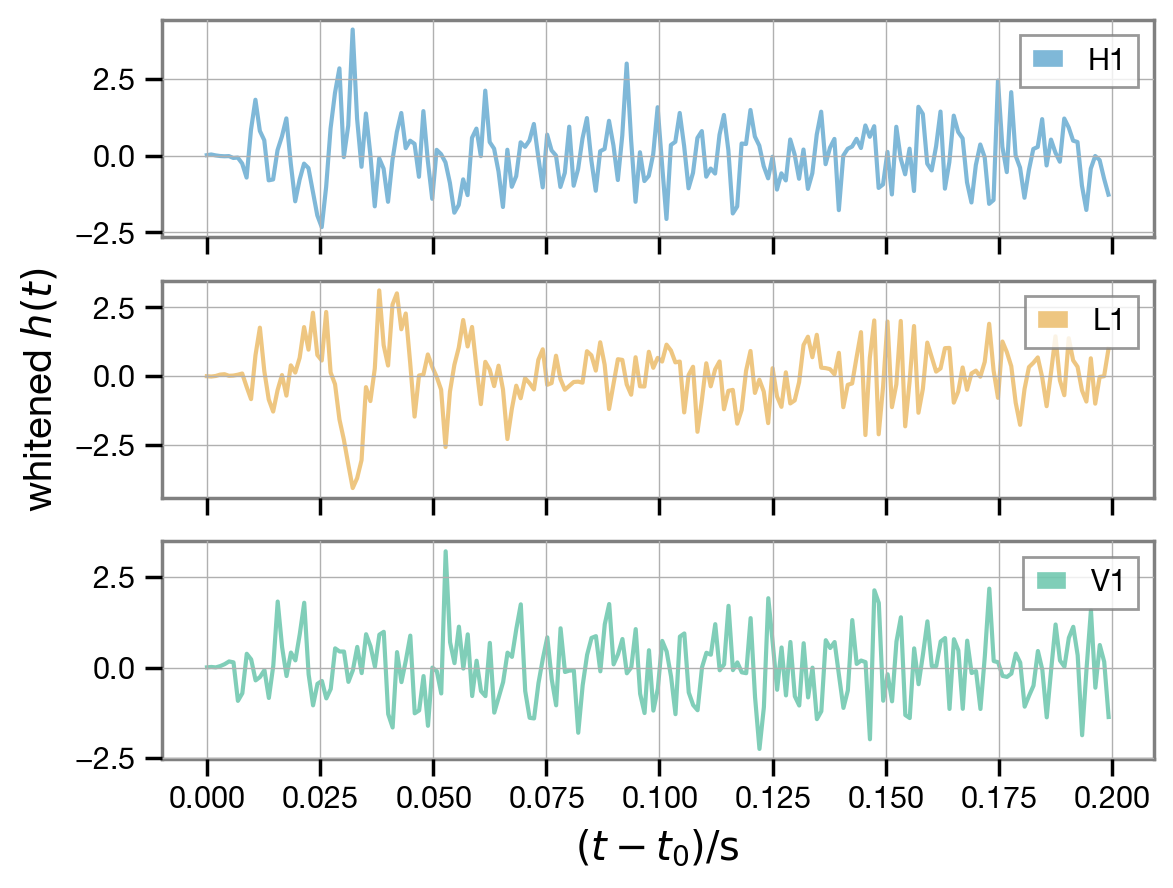

In [17]:
wd = fit.whiten(fit.analysis_data)

fig, axs = plt.subplots(len(fit.ifos), 1, sharex=True)
axs = np.atleast_1d(axs)
for (ifo, d), (i,ax) in zip(wd.items(), enumerate(axs)):
    t0 = fit.start_times[ifo]
    ax.plot(d.time - t0, d, label=ifo, alpha=0.5, c=f'C{i}')
    ax.legend(loc='upper right');
axs[len(axs)//2].set_ylabel(r'whitened $h(t)$');
axs[-1].set_xlabel(r'$(t - t_0) / \mathrm{s}$');

The signal is visible towards the beginning of the whitened data.

### Run fit

We are basically ready to run our fit---all that is left is to specify some prior settings. For a vanilla Kerr fit with generic mode polarizations (not parametrized in terms of a source inclination), we only need to specify an amplitude scale, and a mass range.

In [18]:
fit.update_model(a_scale_max=2e-20, m_min=128, m_max=512, chi_max=0.99)

Now we are ready to run! By default, we will run four parallel chains, but this can be controlled through arguments to `fit.run()` (see docs).

In [19]:
fit.run()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

We can visualize the result of the fit using a trace plot. This allows us to visualize the chains and diagnose any potential divergences.

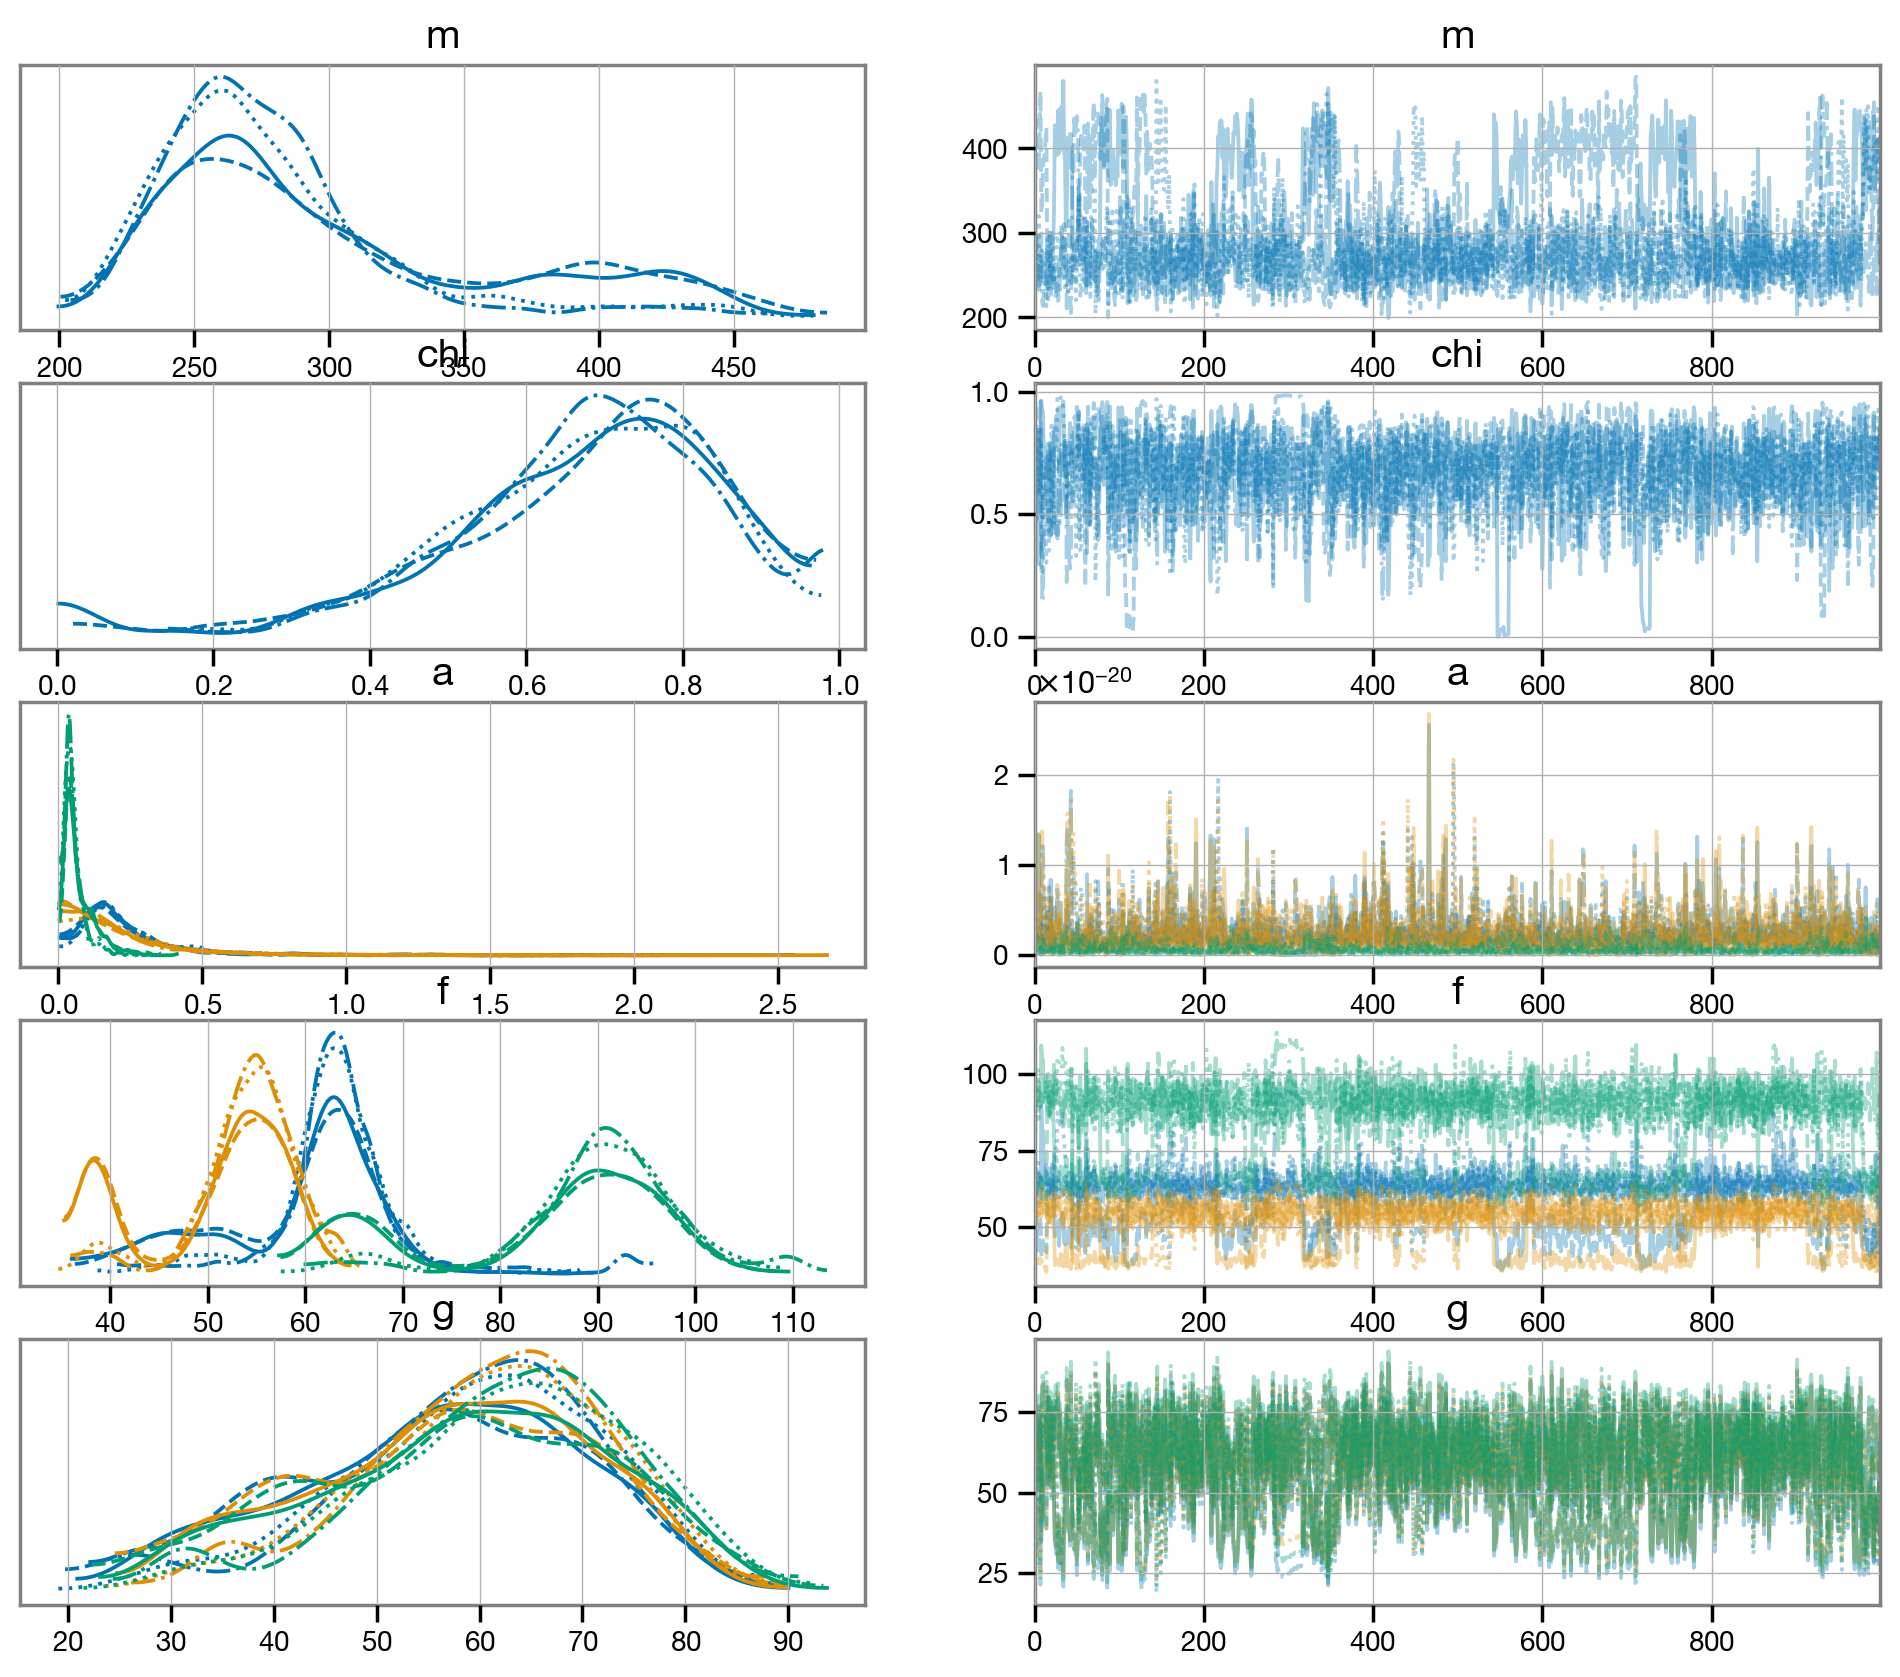

In [20]:
az.plot_trace(fit.result, var_names=['m', 'chi', 'a', 'f', 'g']);

### Plot results

Let's make some useful plots. To facilitate this, let's extract the samples (with all chains stacked together) from our result into a _pandas_ `DataFrame`, a more digestible format for the _seaborn_ plotting library. We will also randomly select a subset of all available samples to make plotting faster; we will do the same for the IMR reference samples from the LVK that we loaded towards the beginning of this notebook.

In [21]:
rd_samples = fit.result.get_parameter_dataframe(500)
df_imr = imr_samples.sample(500)

The `df_imr` subset of IMR samples is still contained in an `rd.IMRResult` object; we will use that to compute ringdown mode frequencies below. This set of IMR samples already contains information about the expected remnant mass and spin but, otherwise, we could use `IMRResult` to compute them automatically (see docs).

#### Remnant mass and spin

Let's we can plot our inferred remnant mass and spin, and compare it to the IMR result; we expect overlap if our ringdown fit is in agreement with the reference IMR analysis.

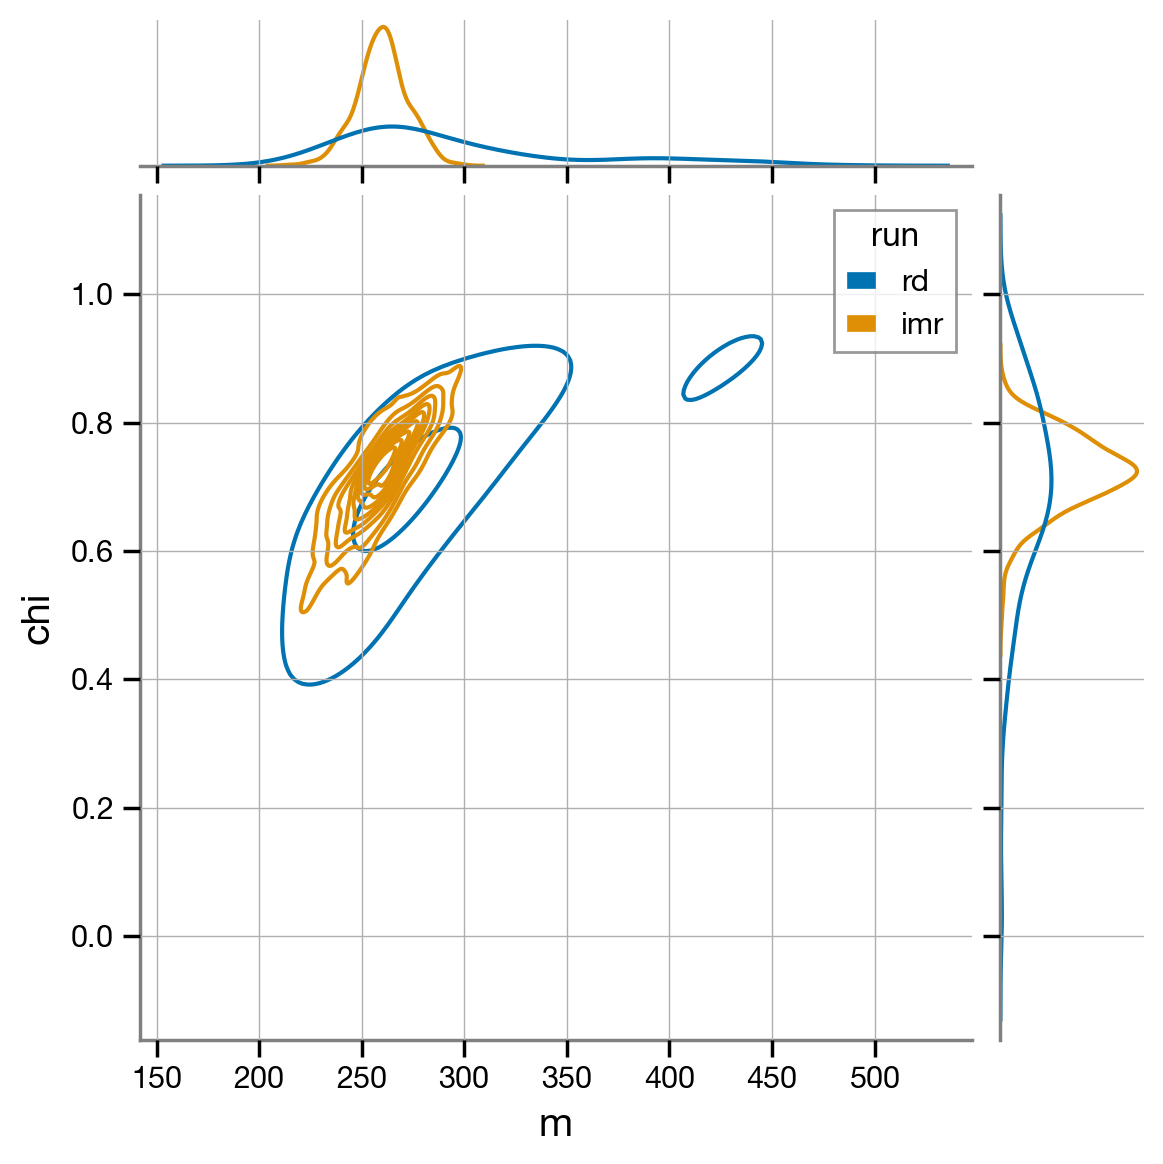

In [22]:
df = rd_samples[['m', 'chi']].copy()
df['run'] = 'rd'

df2 = pd.DataFrame({'m': df_imr.final_mass, 'chi': df_imr.final_spin, 'run': 'imr'})
df = pd.concat([df, df2], ignore_index=True)
sns.jointplot(data=df, x='m', y='chi', kind='kde', hue='run', fill=False);

The remnant mass and spin estimated from the IMR and ringdown runs agree very well.

#### Mode frequencies

We can also extract the frequencies and damping times of individual modes. For the ringdown results, this is straightforward as the individual mode frequencies are automatically stored in the output from our sampler (contained in `fit.result.posterior`); for convenience, we can extract them into another `DataFrame` using `get_mode_parameter_dataframe`. Now, instead of having a column for the frequency and damping rate of each mode (e.g., columns will be labeled `f_220`, `g_220`, ...), all mode parameters will be stacked and a new `mode` column will indicate the identity of the QNM (i.e., columns will be labeled `f`, `g`, `mode`).

This makes it easier to plot multiple mode parameters on the same axes.

In [23]:
rd_freqs = fit.result.get_mode_parameter_dataframe(500)

We can do the same for the IMR results by calling `get_mode_parameter_dataframe` on the `IMRResult` object, with a list of modes. The first time this is called, the object will have to first compute the frequencies and damping rates corresponding to each remnant mass and spin samples; those values are cached internally, speeding up subsequent evaluations.

In [24]:
imr_freqs = df_imr.get_mode_parameter_dataframe(fit.modes)

With those two convenient `DataFrames` in hand, it is now easy to create a plot of mode frequencies and damping rates. We will plot 90\%-credible regions for the IMR result overlaid with points drawn from the ringdown posterior.

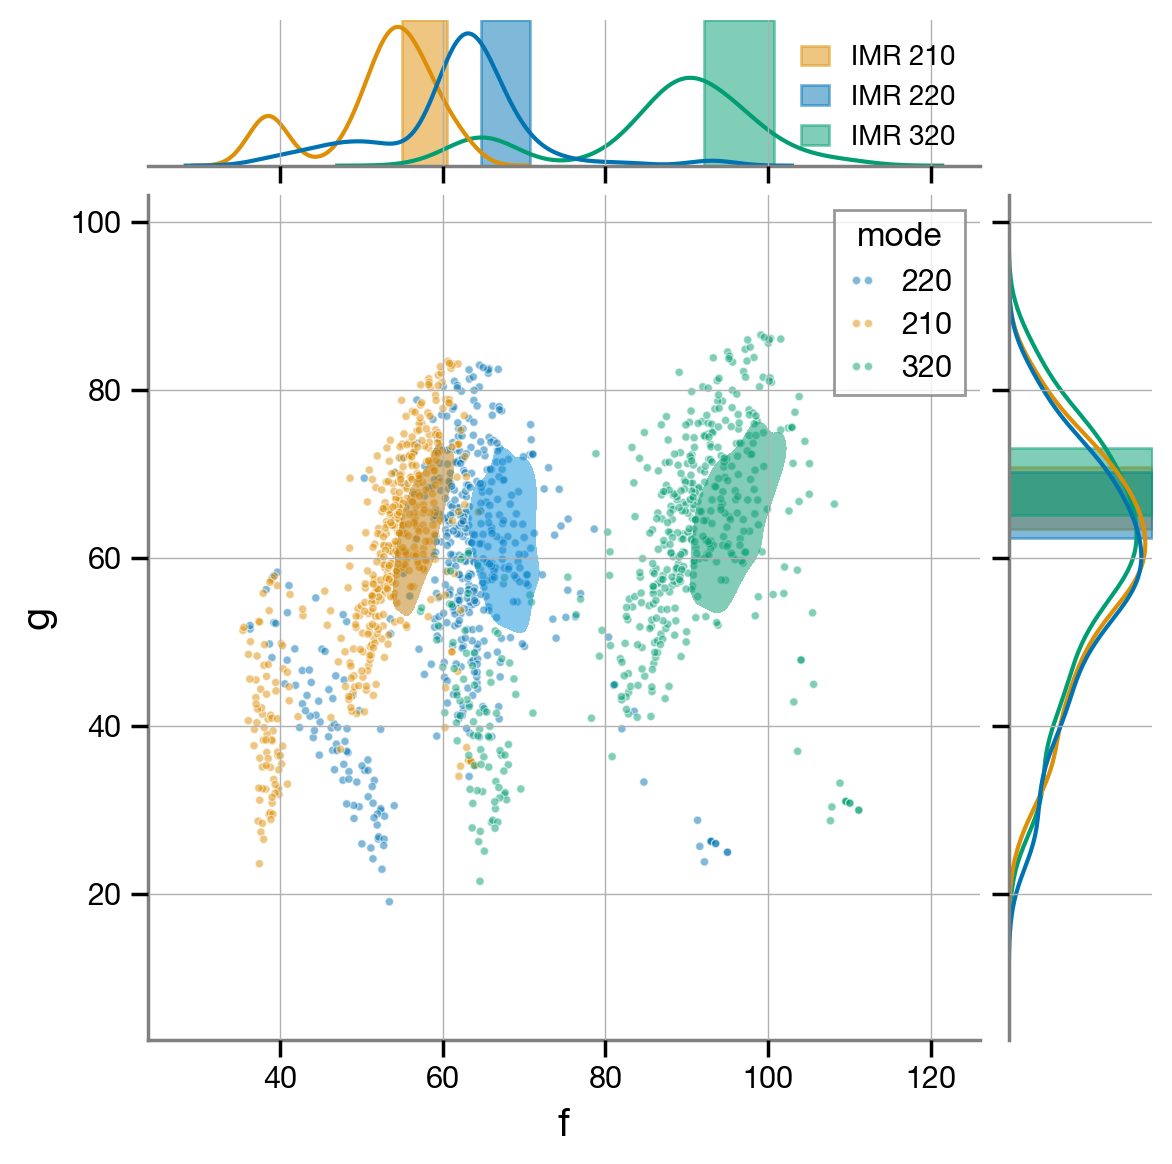

In [25]:
mode_colors = {m.get_label(): f'C{i}' for i,m in enumerate(fit.modes)}
g = sns.JointGrid(x='f', y='g', hue='mode', data=rd_freqs)
g.plot_joint(sns.scatterplot, alpha=0.5, marker='.')
g.plot_marginals(sns.kdeplot)

for m, d in imr_freqs.groupby('mode'):
    # plot joint
    sns.kdeplot(data=d, x='f', y='g', ax=g.ax_joint, color=mode_colors[m], 
                levels=[0.1,1], fill=True, alpha=0.5)
    # plot marginal x
    u, l = d['f'].quantile([.05, .95])
    _, ymax = g.ax_marg_x.get_ylim()
    g.ax_marg_x.fill_betweenx([0, ymax], u, l, color=mode_colors[m], alpha=0.5,
                              label=f'IMR {m}')
    g.ax_marg_x.set_ylim(0, ymax)
    # plot marginal y
    u, l = d['g'].quantile([.5, .95])
    _, xmax = g.ax_marg_y.get_xlim()
    g.ax_marg_y.fill_between([0, xmax], u, l, color=mode_colors[m], alpha=0.5)
    g.ax_marg_y.set_xlim(0, xmax)
g.ax_marg_x.legend(loc='upper right', #ncol=fit.n_modes,
                   fontsize='small', columnspacing=0.5, frameon=False);
    

We recover the expected frequencies and damping rates, for the most part. We do see a bit of mode switching: there's a possible solution in which the model uses the 320 mode to match what we believe from IMR to be the frequency of the 220 mode, and the 220 mode to match the 210 mode, while the 210 mode in the template is placed at a very low frequency (~40 Hz) and hidden below the noise. As discussed in Siegel et al (2023), this can easily be cleaned up by imposing a lower limit on the frequency of the frequency of the 320 mode (say, ~80 Hz). You can easily do that with the samples above, if you wish.

#### Signal-to-noise ratio (optimal and matched-filter)

We can compute the network optimal and matched-filter signal-to-noise ratios (SNRs) recovered by our ringdown analysis.

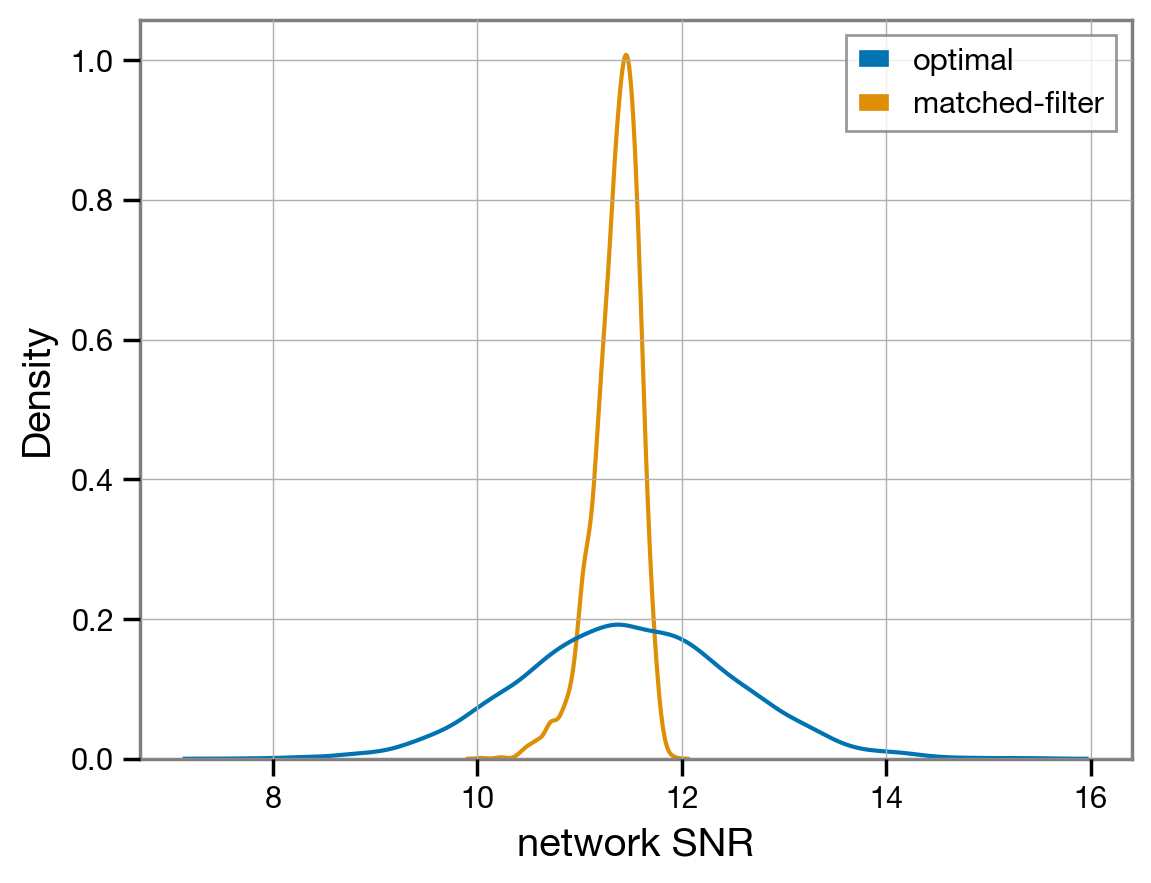

In [26]:
snrs_opt = fit.result.compute_posterior_snrs(network=True)
snrs_mf = fit.result.compute_posterior_snrs(network=True, optimal=False)
sns.kdeplot({'optimal': snrs_opt, 'matched-filter': snrs_mf});
# plt.axvline(np.median(snrs), ls='--')
plt.xlabel('network SNR');

The recovered matched-filter network SNR is a little around $\mathrm{SNR} \sim 11.5$.

The network SNR adds all interferometers in quadrature. We can also look at the individual detectors and see which one contributes most to this signal.

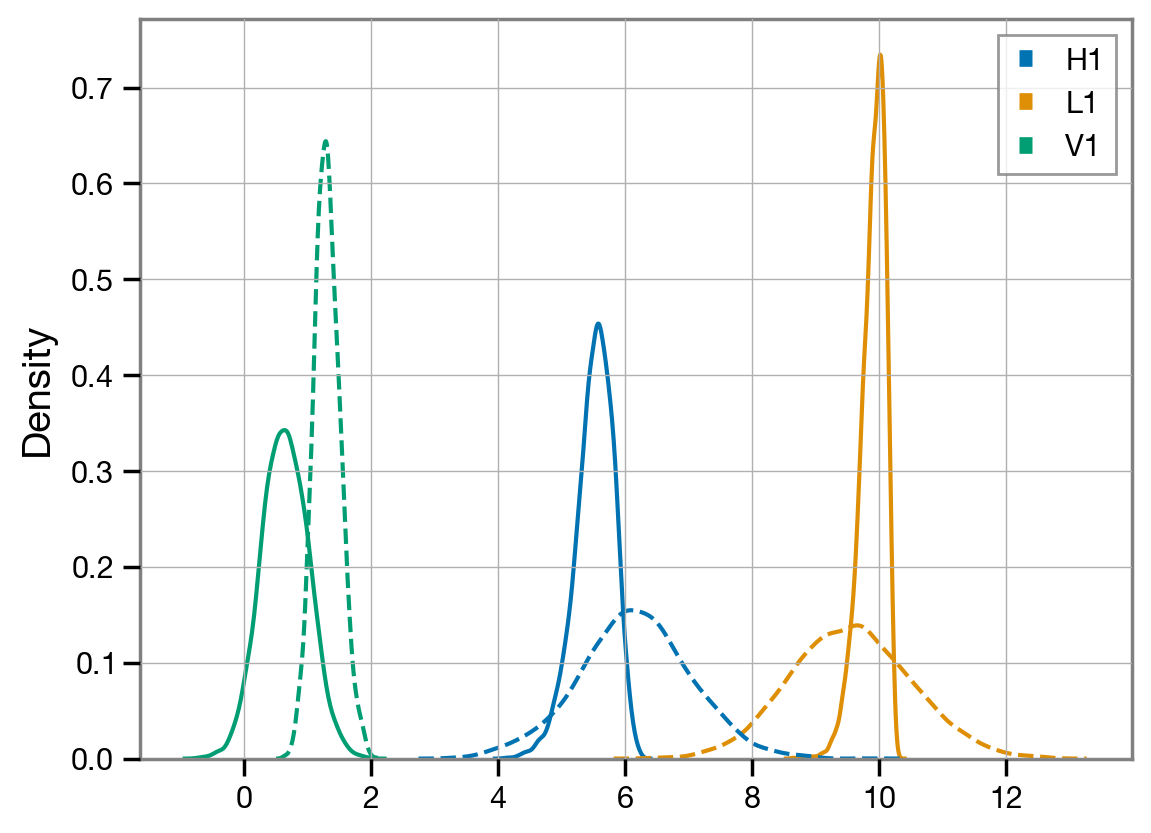

In [27]:
snrs_ifo_opt = fit.result.compute_posterior_snrs(network=False)
snrs_ifo_mf = fit.result.compute_posterior_snrs(network=False, optimal=False)

sns.kdeplot(dict(zip(fit.ifos, snrs_ifo_mf)));
sns.kdeplot(dict(zip(fit.ifos, snrs_ifo_opt)), ls='--');

#### Signal-to-noise ratio time series

The above represents the total SNR accumulated over the whole analysis segment. It is often interesting to check how this SNR is accumulated over time, as the upper limit of integration is progressively increased; we call this cumulative SNR an _SNR timeseries_. Looking at the cumulative SNR is a useful diagnostic to check that the analysis segment length was sufficiently long to capture the full signal in the data, given the ACF of the noise: we want the cumulative SNR curve to stop growing and flatten well before the end of our segment.

The `fit.result` object contains a handy method to automatically compute the cumulative SNR timeseries, whether for the optimal SNR or the matched filter SNR, and for both the whole network or individual detectors. This is computed for each sample in the posterior. 

In [28]:
snr_times_ifo = fit.result.compute_posterior_snrs(optimal=True, network=False, cumulative=True)
snr_times_ifo.shape

(3, 205, 4000)

We can now plot the median over the posterior samples, as well as the symmetric 90\%-credible band around it.

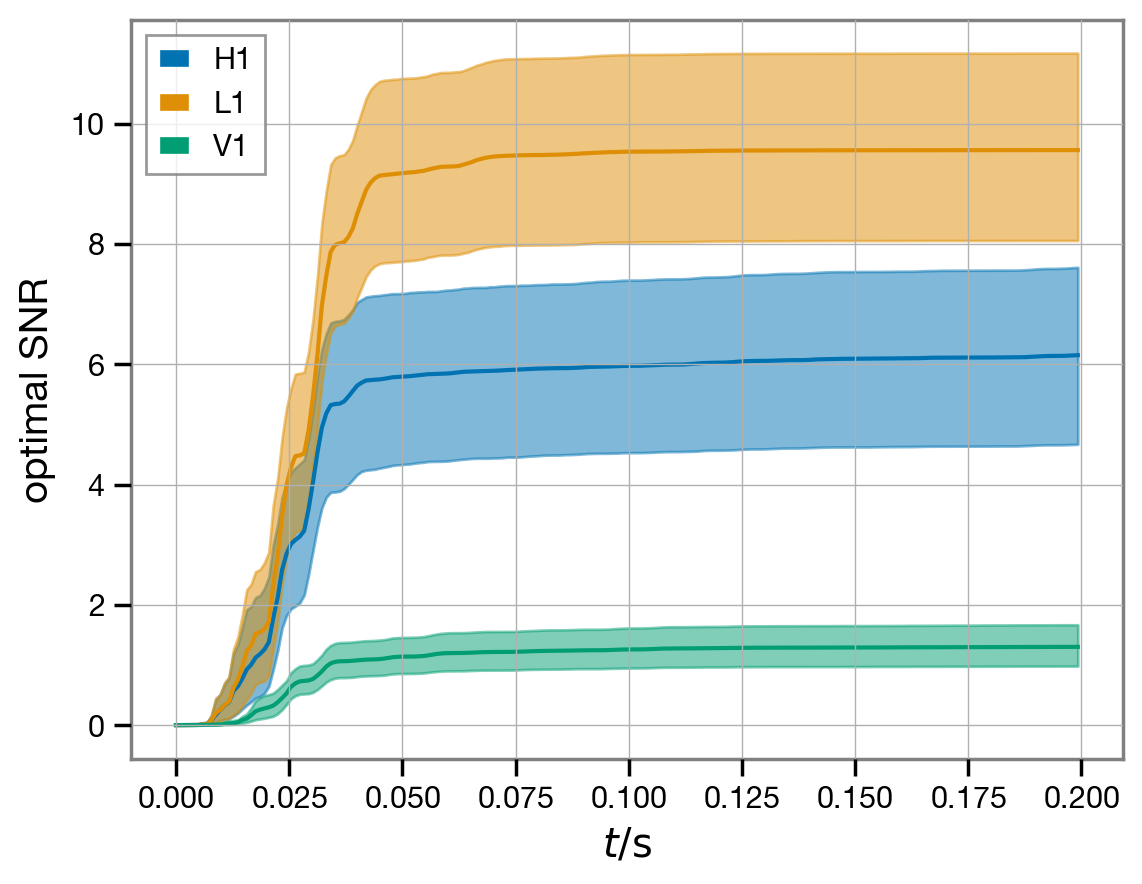

In [29]:
l, m, h = np.quantile(snr_times_ifo, [0.05, 0.5, 0.95], axis=2)
t = fit.analysis_times[fit.ifos[0]] - fit.start_times[fit.ifos[0]]

for i, ifo in enumerate(fit.ifos):
    plt.fill_between(t, l[i], h[i], alpha=0.5, color=f'C{i}')
    plt.plot(t, m[i], label=ifo, c=f'C{i}')

plt.legend(loc='best');
plt.xlabel(r'$t / \mathrm{s}$');
plt.ylabel('optimal SNR');

The SNR time-series seems to have stabilized with the slight exception of the Hanford (H1) detector; for a production analysis, it would be advisable to extend the duration of the analysis segment to get the the full SNR available in Hanford, but we judge this to be acceptable for the purpose of this demonstration.